In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%cd -q ..

/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import lcpfn
import numpy as np
from matplotlib import pyplot as plt
import lcdb
import torch
from scipy.interpolate import interp1d


## Generate samples from LCDB prior

In [7]:
a = lcdb.get_all_curves()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508
...,...,...,...,...,...,...,...,...,...,...
1953366,1464,sklearn.linear_model.SGDClassifier,181,75,4,4,0.0010,0.8011,0.7647,0.7600
1953367,1464,sklearn.linear_model.SGDClassifier,256,75,4,4,0.0012,0.7734,0.7647,0.7600
1953368,1464,sklearn.linear_model.SGDClassifier,362,75,4,4,0.0015,0.7735,0.7647,0.7600
1953369,1464,sklearn.linear_model.SGDClassifier,512,75,4,4,0.0018,0.4395,0.3676,0.4533


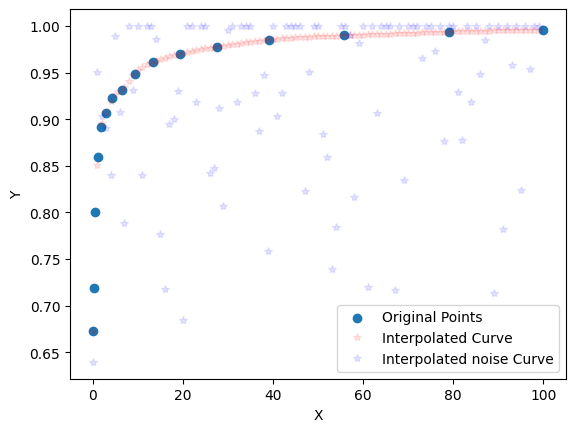

anchors (16,)
means (16,)
x_smooth (100,)
y_smooth (100,)


In [4]:
# for _ in range(50):
#     prior = lcpfn.sample_from_prior(np.random)
#     curve, _ = prior()
#     plt.plot(curve, "*", alpha=0.1)
# plt.ylim(0, 1)
# plt.show()


def get_validation_curve(dataset_id, model):
    """Retrieve the validation curve for a given model and dataset."""
    try:
        anchors, _, scores_valid, _ = lcdb.get_curve(dataset_id, model)
        means = [np.mean(sublist) for sublist in scores_valid]
        return anchors, means

    except Exception as e:
        print(f"Error with dataset_id: {dataset_id} and model: {model} - {str(e)}")
        return None, None


# Create a function that generates a batch of samples from the LCBD dataset

def get_noise_bounds(dataset_id, model):
    """Retrieve the validation curve for a given model and dataset."""
    try:
        _, _, _, scores_test = lcdb.get_curve(dataset_id, model)
        means = [max(sublist) - min(sublist) for sublist in scores_test]
        return  np.std(means)

    except Exception as e:
        print(f"Error with dataset_id: {dataset_id} and model: {model} - {str(e)}")
        return None, None

def sample_from_lcbd(n:np.random, plot=False, seq_len=100):
    """Sample a learning curve from the LCBD dataset."""
    dataset_id = n.choice(lcdb.DATASET_IDS)
    model = n.choice(lcdb.MODELS)

    anchors, means = get_validation_curve(dataset_id, model)


    return sample(n, components=None, distribution=None, plot=plot)



def sample(rng:np.random,
            components,
            distribution,
            var_lnloc=-4,
            var_lnscale=1,
            range_constraint=True,
            seq_len=100,
            dataset_id=3,
            model="sklearn.tree.DecisionTreeClassifier",
            plot=False):

    if type(dataset_id) == list:
        dataset_id = rng.choice(dataset_id)
    if type(model) == list:
        model = rng.choice(model)

    anchors, means = get_validation_curve(dataset_id, model)

    means = np.array(means)
    #change the anchors to be between 0 and 1
    anchors = np.array(anchors)
    anchors = (anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))
    f = interp1d(anchors, means, kind='cubic')
    x_smooth = np.linspace(min(anchors), max(anchors), seq_len)
    y_smooth = f(x_smooth)

    std = get_noise_bounds(dataset_id, model)
    y_noise = rng.normal(0, std, seq_len)
    y_noise = y_smooth + y_noise
    y_noise = np.clip(y_noise, 0, 1)

    if plot:
        plt.scatter(anchors*100, means, label='Original Points')
        plt.plot(y_smooth, "*" ,label='Interpolated Curve', color='red', alpha=0.1)
        plt.plot(y_noise,  "*", label='Interpolated noise Curve', color='blue', alpha=0.1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.show()

        print("anchors", anchors.shape)
        print("means", means.shape)
        print("x_smooth", x_smooth.shape)
        print("y_smooth", y_smooth.shape)

    def curve():
        return y_smooth, y_noise
    return curve


y = sample_from_lcbd(np.random, plot=True)


## Train a PFN model with the previous learning curve prior

In [7]:
get_batch_func = lcpfn.create_get_batch_func(prior=sample_from_lcbd)
# lcpfn.sample_from_prior() or sample_from_lcbd

In [9]:
# example of a batch
X, Y, y_noise = get_batch_func(batch_size=100, seq_len=100, num_features=1)
print(X.shape, Y.shape, y_noise.shape)

KeyboardInterrupt: 

In [ ]:
# Main function to train a PFN model
lcpfn.train_lcpfn

In [ ]:
# train a small model for 3 epochs

result = lcpfn.train_lcpfn(get_batch_func=get_batch_func, 
                          seq_len=100,
                         emsize=256,
                         nlayers=3,
                         num_borders=1000,
                         lr=0.001,
                         batch_size=10,
                         epochs=3)

In [ ]:
# Get the trained model

model = result[2]
print(model)

NameError: name 'result' is not defined